###
The script used to acquire all of the following data can be found in this GitHub repository. This repository also contains the modeling codes and will be updated continually, so welcome starring or watching!

Stock market data can be interesting to analyze and as a further incentive, strong predictive models can have large financial payoff. The amount of financial data on the web is seemingly endless. A large and well structured dataset on a wide array of companies can be hard to come by. Here provided a dataset with historical stock prices (last 12 years) for 29 of 30 DJIA companies (excluding 'V' because it does not have the whole 12 years data).

  ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 'GE',

  'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE',

  'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT', 'GOOGL', 'AMZN', 'AABA']
Content
The data is presented in a couple of formats to suit different individual's needs or computational limitations. I have included files containing 13 years of stock data (in the all_stocks_2006-01-01_to_2018-01-01.csv and corresponding folder) and a smaller version of the dataset (all_stocks_2017-01-01_to_2018-01-01.csv) with only the past year's stock data for those wishing to use something more manageable in size.

The folder individual_stocks_2006-01-01_to_2018-01-01 contains files of data for individual stocks, labelled by their stock ticker name. The all_stocks_2006-01-01_to_2018-01-01.csv and all_stocks_2017-01-01_to_2018-01-01.csv contain this same data, presented in merged .csv files. Depending on the intended use (graphing, modelling etc.) the user may prefer one of these given formats.

All the files have the following columns: Date - in format: yy-mm-dd

Open - price of the stock at market open (this is NYSE data so all in USD)

High - Highest price reached in the day

Low Close - Lowest price reached in the day

Volume - Number of shares traded

Name - the stock's ticker name

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
data = pd.read_csv('/Users/vbaderdi/Downloads/IBM_2006-01-01_to_2018-01-01.csv')
data = data[data['Name'] == 'IBM']  # Selecting Apple stock as an example
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
# Selecting Close price for prediction
prices = data[['Close']].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Prepare data for LSTM
look_back = 60  # Number of past days used for prediction
X, Y = [], []
for i in range(len(prices_scaled) - look_back):
    X.append(prices_scaled[i:i + look_back, 0])
    Y.append(prices_scaled[i + look_back, 0])
X, Y = np.array(X), np.array(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)


In [4]:
# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X_tensor[:split], X_tensor[split:]
Y_train, Y_test = Y_tensor[:split], Y_tensor[split:]

# Create DataLoaders
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])


Epoch 1/20, Loss: 0.004283
Epoch 2/20, Loss: 0.000956
Epoch 3/20, Loss: 0.000457
Epoch 4/20, Loss: 0.000873
Epoch 5/20, Loss: 0.000555
Epoch 6/20, Loss: 0.000755
Epoch 7/20, Loss: 0.001068
Epoch 8/20, Loss: 0.001071
Epoch 9/20, Loss: 0.000592
Epoch 10/20, Loss: 0.000554
Epoch 11/20, Loss: 0.000879
Epoch 12/20, Loss: 0.000327
Epoch 13/20, Loss: 0.000673
Epoch 14/20, Loss: 0.000455
Epoch 15/20, Loss: 0.000284
Epoch 16/20, Loss: 0.000865
Epoch 17/20, Loss: 0.000319
Epoch 18/20, Loss: 0.000597
Epoch 19/20, Loss: 0.000283
Epoch 20/20, Loss: 0.000382


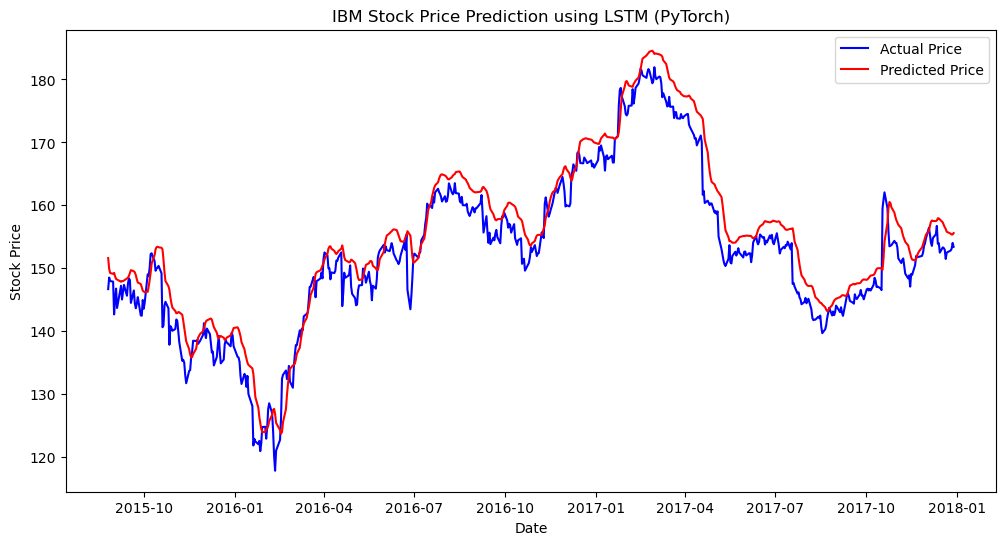

In [6]:
# Instantiate model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
epochs = 20
for epoch in range(epochs):
    model.train()
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# Evaluate model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_predictions = model(batch_X).cpu().numpy()
        predictions.extend(batch_predictions)
        actuals.extend(batch_Y.numpy())

# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data.index[split + look_back:], actuals, color='blue', label='Actual Price')
plt.plot(data.index[split + look_back:], predictions, color='red', label='Predicted Price')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('IBM Stock Price Prediction using LSTM (PyTorch)')
plt.show()